二维热力图

0.4311244590680706
0.5615995315014991


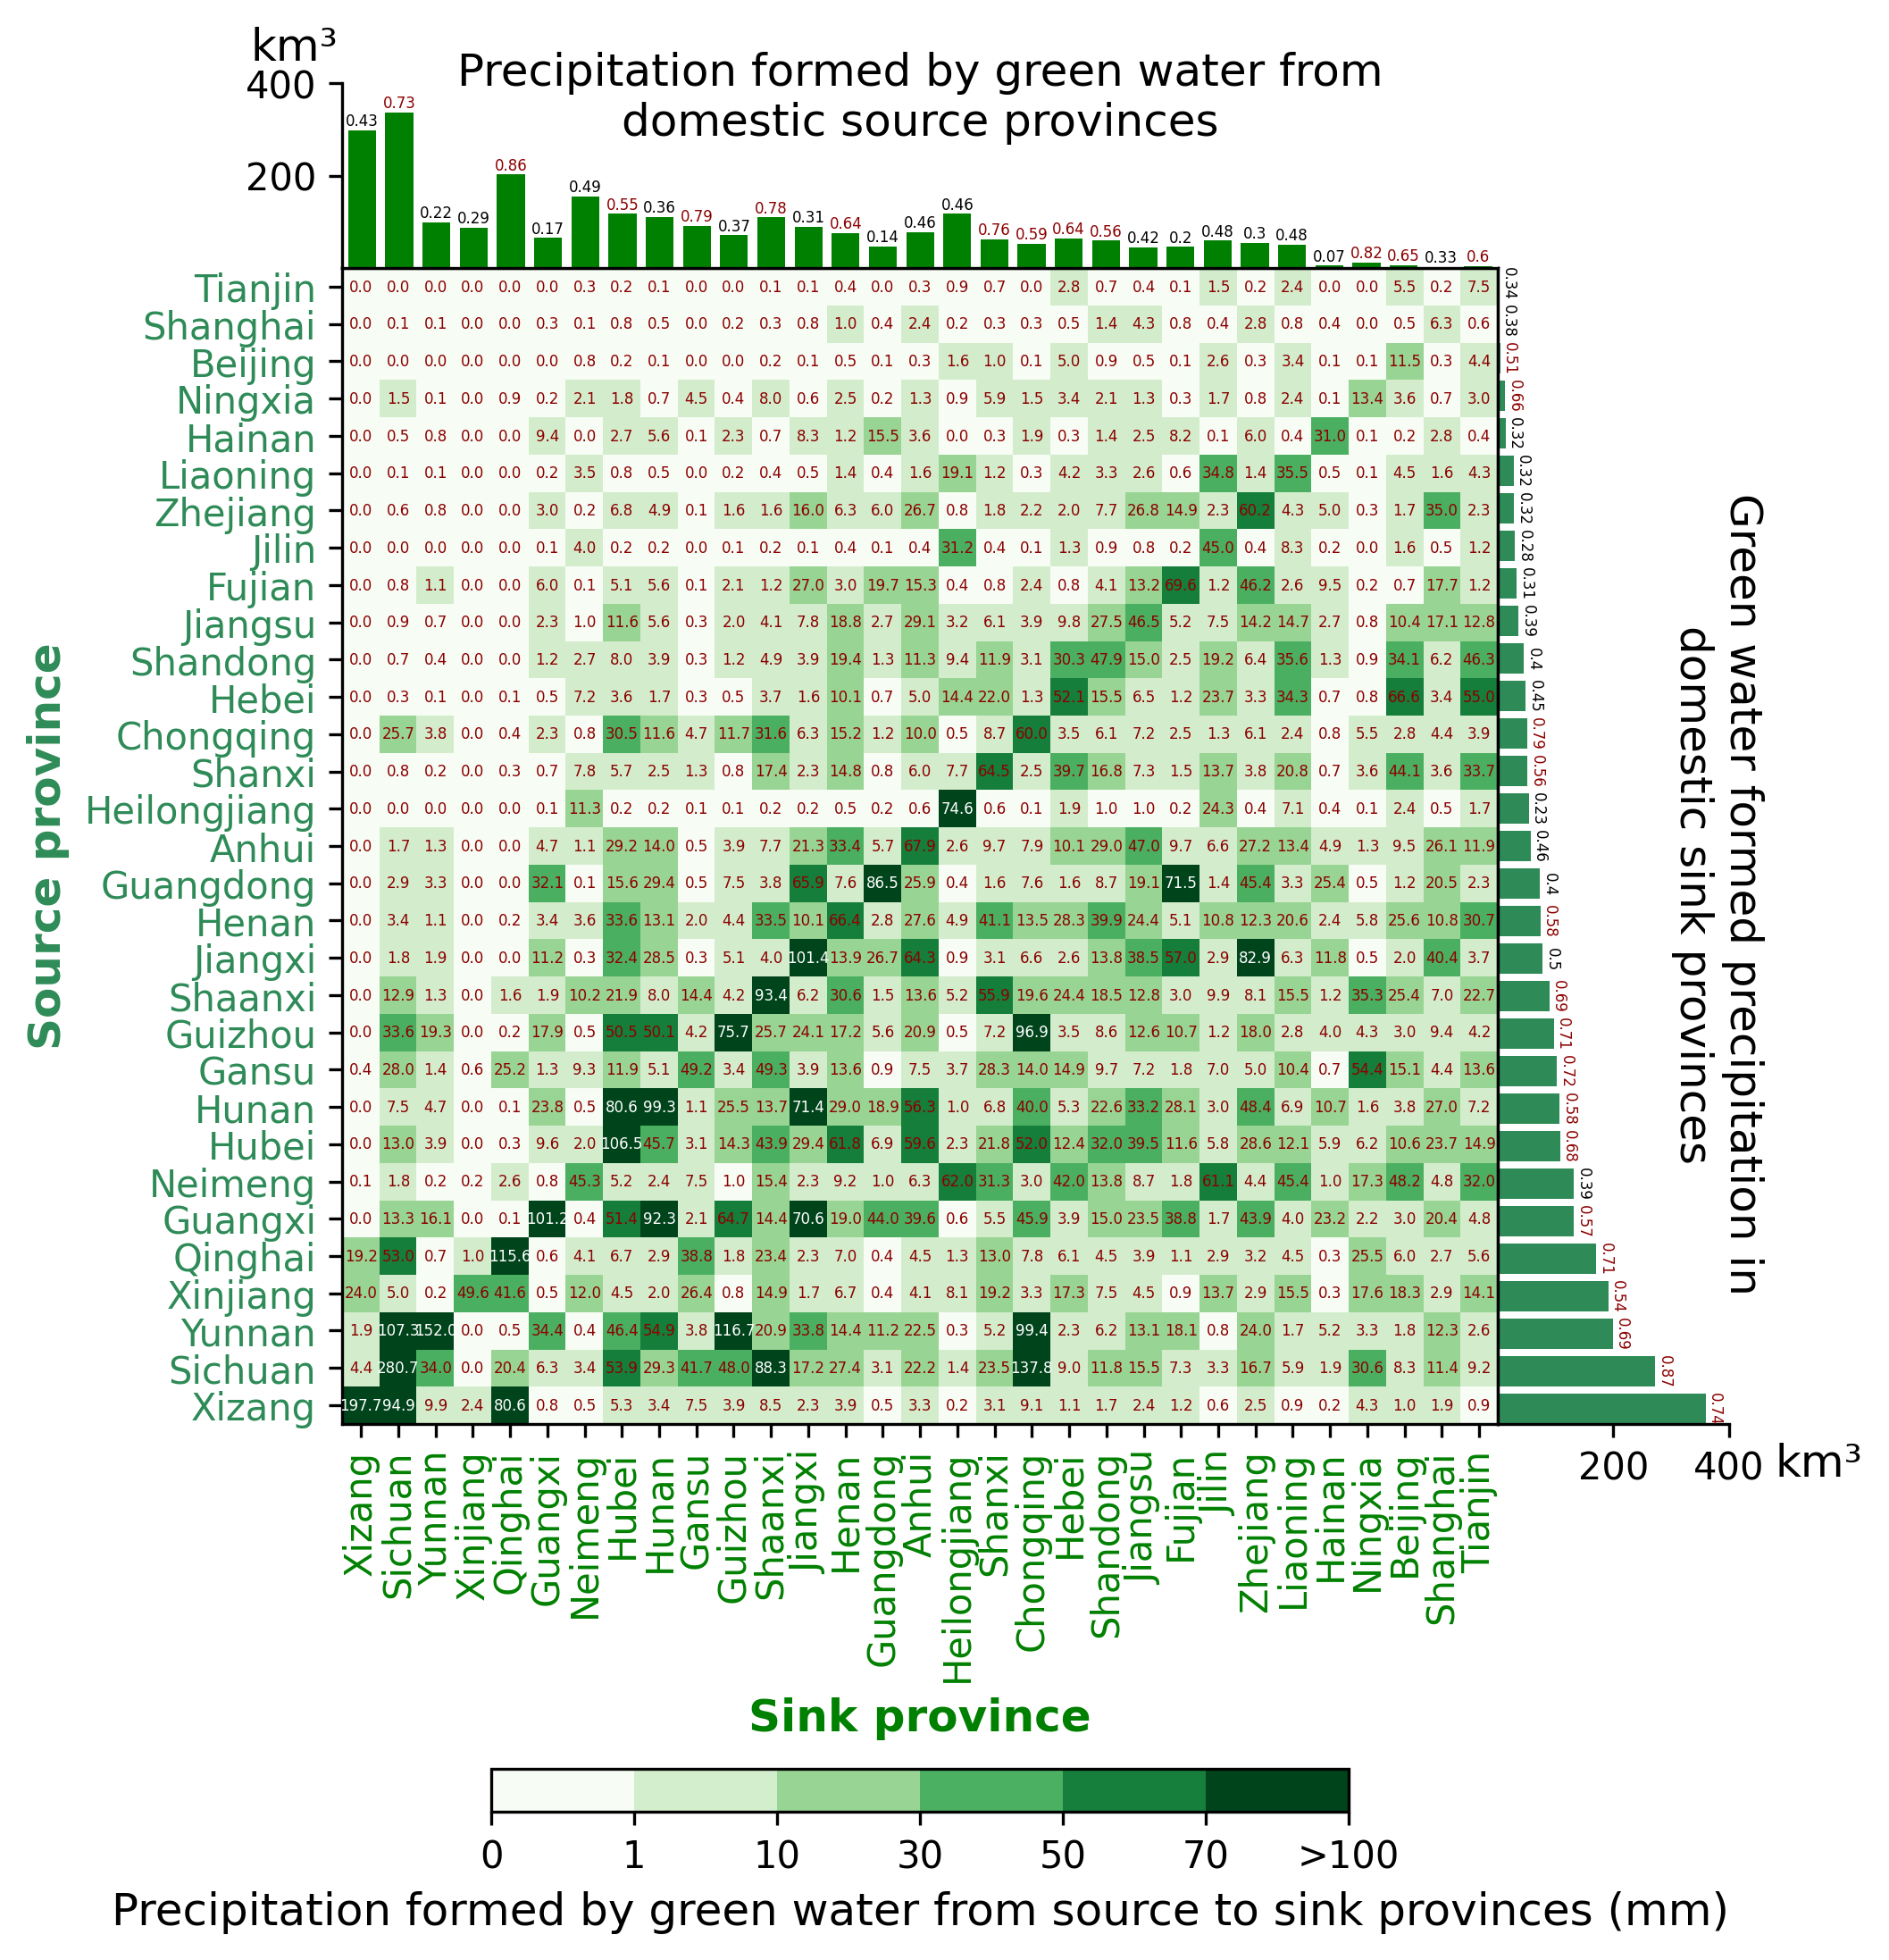

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def data_cal_sort():
    data_pre_relative = pd.read_csv('../data/ET&pre/prec_source_zonal0601.csv')
    pro_ETpre_relative = np.array(data_pre_relative.iloc[0:31,1:32])
    data_h = pd.read_csv('../data/society/GDP&waterwithdrawal.csv')
    ET_data = pd.read_csv('../data/ET&pre/et_zonal_ERA5.csv')
    pro_name_list = data_h['province'].tolist()
    # unit km3
    pro_pre_km3_total = np.array(data_h['average_pre(108m3)']).reshape((1,31))/10
    # unit mm
    pro_pre_mm_total = np.array(data_h['average_pre(mm)']).reshape((1,31))
    # pre formed ET (mm)
    pro_ETpre_mm = pro_ETpre_relative * pro_pre_mm_total
    # pre formed ET (km3)
    pro_ETpre_km3 = pro_ETpre_relative * pro_pre_km3_total
    # domestic pre by ET
    pro_ETpre_km3_sum  =pro_ETpre_km3.sum(axis=1)
    ET_in_dom_ratio = pro_ETpre_km3_sum / (ET_data['et'].values * data_h['area(km2)'].values / 1000000)
    # pre from domestic ET
    pro_ETpre_km3_dom = pro_ETpre_km3.sum(axis=0) 
    # pre from domestic ET / total pre
    pro_ETpre_km3_dom_ratio  =pro_ETpre_km3_dom / (data_h['average_pre(108m3)'].values/10)
    print (pro_ETpre_km3_dom.sum()/(data_h['average_pre(108m3)'].values.sum()/10))
    print (pro_ETpre_km3_sum.sum()/(ET_data['et'].values * data_h['area(km2)'].values / 1000000).sum())

    # sort
    sorted_index = np.argsort(pro_ETpre_km3_sum)[::-1]
    # pre from domestic ET
    pro_ETpre_km3_dom_sort = pro_ETpre_km3_dom[sorted_index]
    # pre from domestic ET / total pre
    pro_ETpre_km3_dom_rasort = np.array(pro_ETpre_km3_dom_ratio[sorted_index])
    # domestic pre by ET
    pro_ETpre_km3_sum_sort = pro_ETpre_km3_sum[sorted_index]
    # pre formed ET (mm)
    pro_ETpre_mm_sort = pro_ETpre_mm[sorted_index, :]
    pro_ETpre_mm_sort = pro_ETpre_mm_sort[:,sorted_index]
    
    pro_name_list_sort = np.array(pro_name_list)[sorted_index]
    # domestic pre by ET / total ET
    ET_in_dom_ratio_sort = np.array(ET_in_dom_ratio)[sorted_index]

    return pro_ETpre_mm_sort,pro_ETpre_km3_dom_sort,pro_ETpre_km3_dom_rasort,pro_ETpre_km3_sum_sort,pro_name_list_sort,ET_in_dom_ratio_sort

pro_ETpre_mm_sort,pro_ETpre_km3_dom_sort,pro_ETpre_km3_dom_rasort,pro_ETpre_km3_sum_sort,pro_name_list_sort,ET_in_dom_ratio_sort = data_cal_sort()

# plot
def heatmap(ax):
    for i in range(pro_ETpre_mm_sort.shape[0]):
        for j in range(pro_ETpre_mm_sort.shape[1]):
            if pro_ETpre_mm_sort[i, j] > 70:
                ax.text(j,i,round(pro_ETpre_mm_sort[i,j],1), ha='center', va='center', color='white',fontsize=4)
            else:
                ax.text(j,i,round(pro_ETpre_mm_sort[i,j],1), ha='center', va='center', color='darkred',fontsize=4)

    ax.set_xticks(np.arange(len(pro_name_list_sort)), labels=pro_name_list_sort, rotation=90, rotation_mode='anchor', ha='right',va='center', color='green')
    ax.set_xlabel('Sink province', color='green',weight='bold',fontsize=12)
    ax.set_ylabel('Source province',color='#2E8B57',weight='bold',fontsize=12)
    ax.set_yticks(np.arange(len(pro_name_list_sort)), labels=pro_name_list_sort,color = '#2E8B57')
    
    ax.xaxis.tick_bottom()
    ax.xaxis.set_label_position('bottom')

    bins = [0,1,10,30,50,70,100]
    nbin = len(bins)-1
    cmap = cm.get_cmap('Greens', nbin)
    norm = mcolors.BoundaryNorm(bins, nbin)

    heatmap = ax.imshow(pro_ETpre_mm_sort, cmap=cmap, norm=norm, origin='lower')

    cbar = fig.colorbar(heatmap, ax=ax, location='bottom', pad=0.15)
    cbar.set_ticks(bins)
    cbar.set_ticklabels(['0','1','10','30','50','70','>100'])
    cbar.ax.set_position([ax.get_position().xmin+ax.get_position().width/2-0.2, 0.16, 0.4, 0.02])
    cbar.set_label('Precipitation formed by green water from source to sink provinces (mm)',fontsize=12)

def barh_right(axx):
    axx.barh(np.arange(len(pro_name_list_sort)), pro_ETpre_km3_sum_sort, height=0.8,color='#2E8B57')
    axx.spines['right'].set_visible(False)
    axx.spines['top'].set_visible(False)
    axx.xaxis.tick_bottom()
    x_ticks2 = [200,400]
    axx.set_xticks(x_ticks2)
    axx.margins(y=0.0)
    axx.set_yticklabels([])
    axx.get_yaxis().set_visible(False)
    axx.set_title('Green water formed precipitation in\ndomestic sink provinces',rotation = 270, y=0.1, x=0.95)
    axx.text(480,-1.8,'km\u00B3',color='black',fontsize=12)
    for i in range(len(pro_name_list_sort)):
        if ET_in_dom_ratio_sort[i]>0.5:
            color = 'darkred'
        else:
            color = 'black'
        axx.text(pro_ETpre_km3_sum_sort[i]+30, i, round(ET_in_dom_ratio_sort[i],2), ha='right',va='center', rotation = 270,color=color,fontsize=4)

def bar_top(axx):
    axx.bar(np.arange(len(pro_name_list_sort)), pro_ETpre_km3_dom_sort, color='green',width=0.75)
    axx.spines['right'].set_visible(False)
    axx.spines['top'].set_visible(False)
    axx.xaxis.tick_bottom()
    axx.margins(x=0.005)
    axx.set_xticklabels([])
    axx.get_xaxis().set_visible(False)
    axx.yaxis.tick_left()
    y_ticks = [200,400]
    axx.set_yticks(y_ticks)
    axx.set_title('Precipitation formed by green water from\ndomestic source provinces',y=0.6, x=0.5)
    axx.text(-3,450,'km\u00B3',color='black',fontsize=12)
    for i in range(len(pro_name_list_sort)):
        if pro_ETpre_km3_dom_rasort[i]>0.5:
            color = 'darkred'
        else:
            color = 'black'
        axx.text(i, pro_ETpre_km3_dom_sort[i]+20,round(pro_ETpre_km3_dom_rasort[i],2),ha='center', va='center', color=color,fontsize=4)

fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(111) 
heatmap(ax)
ax2 = fig.add_axes([ax.get_position().xmin+ax.get_position().width,ax.get_position().ymin,ax.get_position().width/5,ax.get_position().height])
barh_right(ax2)
ax3 = fig.add_axes([ax.get_position().xmin,ax.get_position().ymax,4*ax.get_position().height/5,ax.get_position().width/5])
bar_top(ax3)

In [15]:
import numpy as np
import pandas as pd

def data_cal_sort():
    data_pre_relative = pd.read_csv('../data/ET&pre/prec_source_zonal0601.csv')
    pro_ETpre_relative = np.array(data_pre_relative.iloc[0:31,1:32])
    data_h = pd.read_csv('../data/society/GDP&waterwithdrawal.csv')
    pro_name_list = data_h['province'].tolist()
    # 有问题
    ET_in_dom_ratio = pd.read_csv('../data/ET&pre/ET_outer_ratio.csv')['ET_pre_inner/ET_total']
    # unit km3
    pro_pre_km3_total = np.array(data_h['average_pre(108m3)']).reshape((1,31))/10
    # unit mm
    pro_pre_mm_total = np.array(data_h['average_pre(mm)']).reshape((1,31))
    # pre formed ET (mm)
    pro_ETpre_mm = pro_ETpre_relative * pro_pre_mm_total
    # pre formed ET (km3)
    pro_ETpre_km3 = pro_ETpre_relative * pro_pre_km3_total
    # domestic pre by ET
    pro_ETpre_km3_sum  =pro_ETpre_km3.sum(axis=1)
    # domestic pre by ET except local
    pro_ETpre_km3_sum_nolocal  = pro_ETpre_km3.sum(axis=1) - np.diag(pro_ETpre_km3)
    # pre from domestic ET
    pro_ETpre_km3_dom = pro_ETpre_km3.sum(axis=0)
    # pre from domestic ET / total pre
    pro_ETpre_km3_dom_ratio  =pro_ETpre_km3_dom / (data_h['average_pre(108m3)'].values/10)

    return pro_name_list,pro_ETpre_mm,pro_ETpre_km3_dom,pro_ETpre_km3_dom_ratio,pro_ETpre_km3_sum,ET_in_dom_ratio,pro_ETpre_km3_sum_nolocal

pro_name_list,pro_ETpre_mm,pro_ETpre_km3_dom,pro_ETpre_km3_dom_ratio,pro_ETpre_km3_sum,ET_in_dom_ratio,pro_ETpre_km3_sum_nolocal = data_cal_sort()

data_value = np.concatenate((np.array(pro_name_list).reshape(31,1),pro_ETpre_km3_dom.reshape(31,1),
                             pro_ETpre_km3_dom.reshape(31,1),pro_ETpre_km3_sum.reshape(31,1),
                             ET_in_dom_ratio.to_numpy().reshape(31,1),pro_ETpre_km3_sum_nolocal.reshape(31,1)),axis=1)

col_list = ['name','pre from domestic ET','pre from domestic ET/total pre','domestic pre by ET','domestic pre by ET/total ET','domestic pre by ET except local']

data_value = pd.DataFrame(data_value)
data_value.columns=col_list
data_value.to_csv('../data/ET&pre/ET_domestic_value.csv',encoding='utf-8')

C:\Users\dell\AppData\Local\Temp\ipykernel_25300\3875950325.py:41: RuntimeWarning: invalid value encountered in scalar divide
  x_div.loc[target,source] = diff_xy[0]/((diff_xy[0]**2+diff_xy[1]**2)**0.5)
C:\Users\dell\AppData\Local\Temp\ipykernel_25300\3875950325.py:42: RuntimeWarning: invalid value encountered in scalar divide
  y_div.loc[target,source] = diff_xy[1]/((diff_xy[0]**2+diff_xy[1]**2)**0.5)
C:\Users\dell\AppData\Local\Temp\ipykernel_25300\3875950325.py:41: RuntimeWarning: invalid value encountered in scalar divide
  x_div.loc[target,source] = diff_xy[0]/((diff_xy[0]**2+diff_xy[1]**2)**0.5)
C:\Users\dell\AppData\Local\Temp\ipykernel_25300\3875950325.py:42: RuntimeWarning: invalid value encountered in scalar divide
  y_div.loc[target,source] = diff_xy[1]/((diff_xy[0]**2+diff_xy[1]**2)**0.5)
C:\Users\dell\AppData\Local\Temp\ipykernel_25300\3875950325.py:41: RuntimeWarning: invalid value encountered in scalar divide
  x_div.loc[target,source] = diff_xy[0]/((diff_xy[0]**2+diff_x

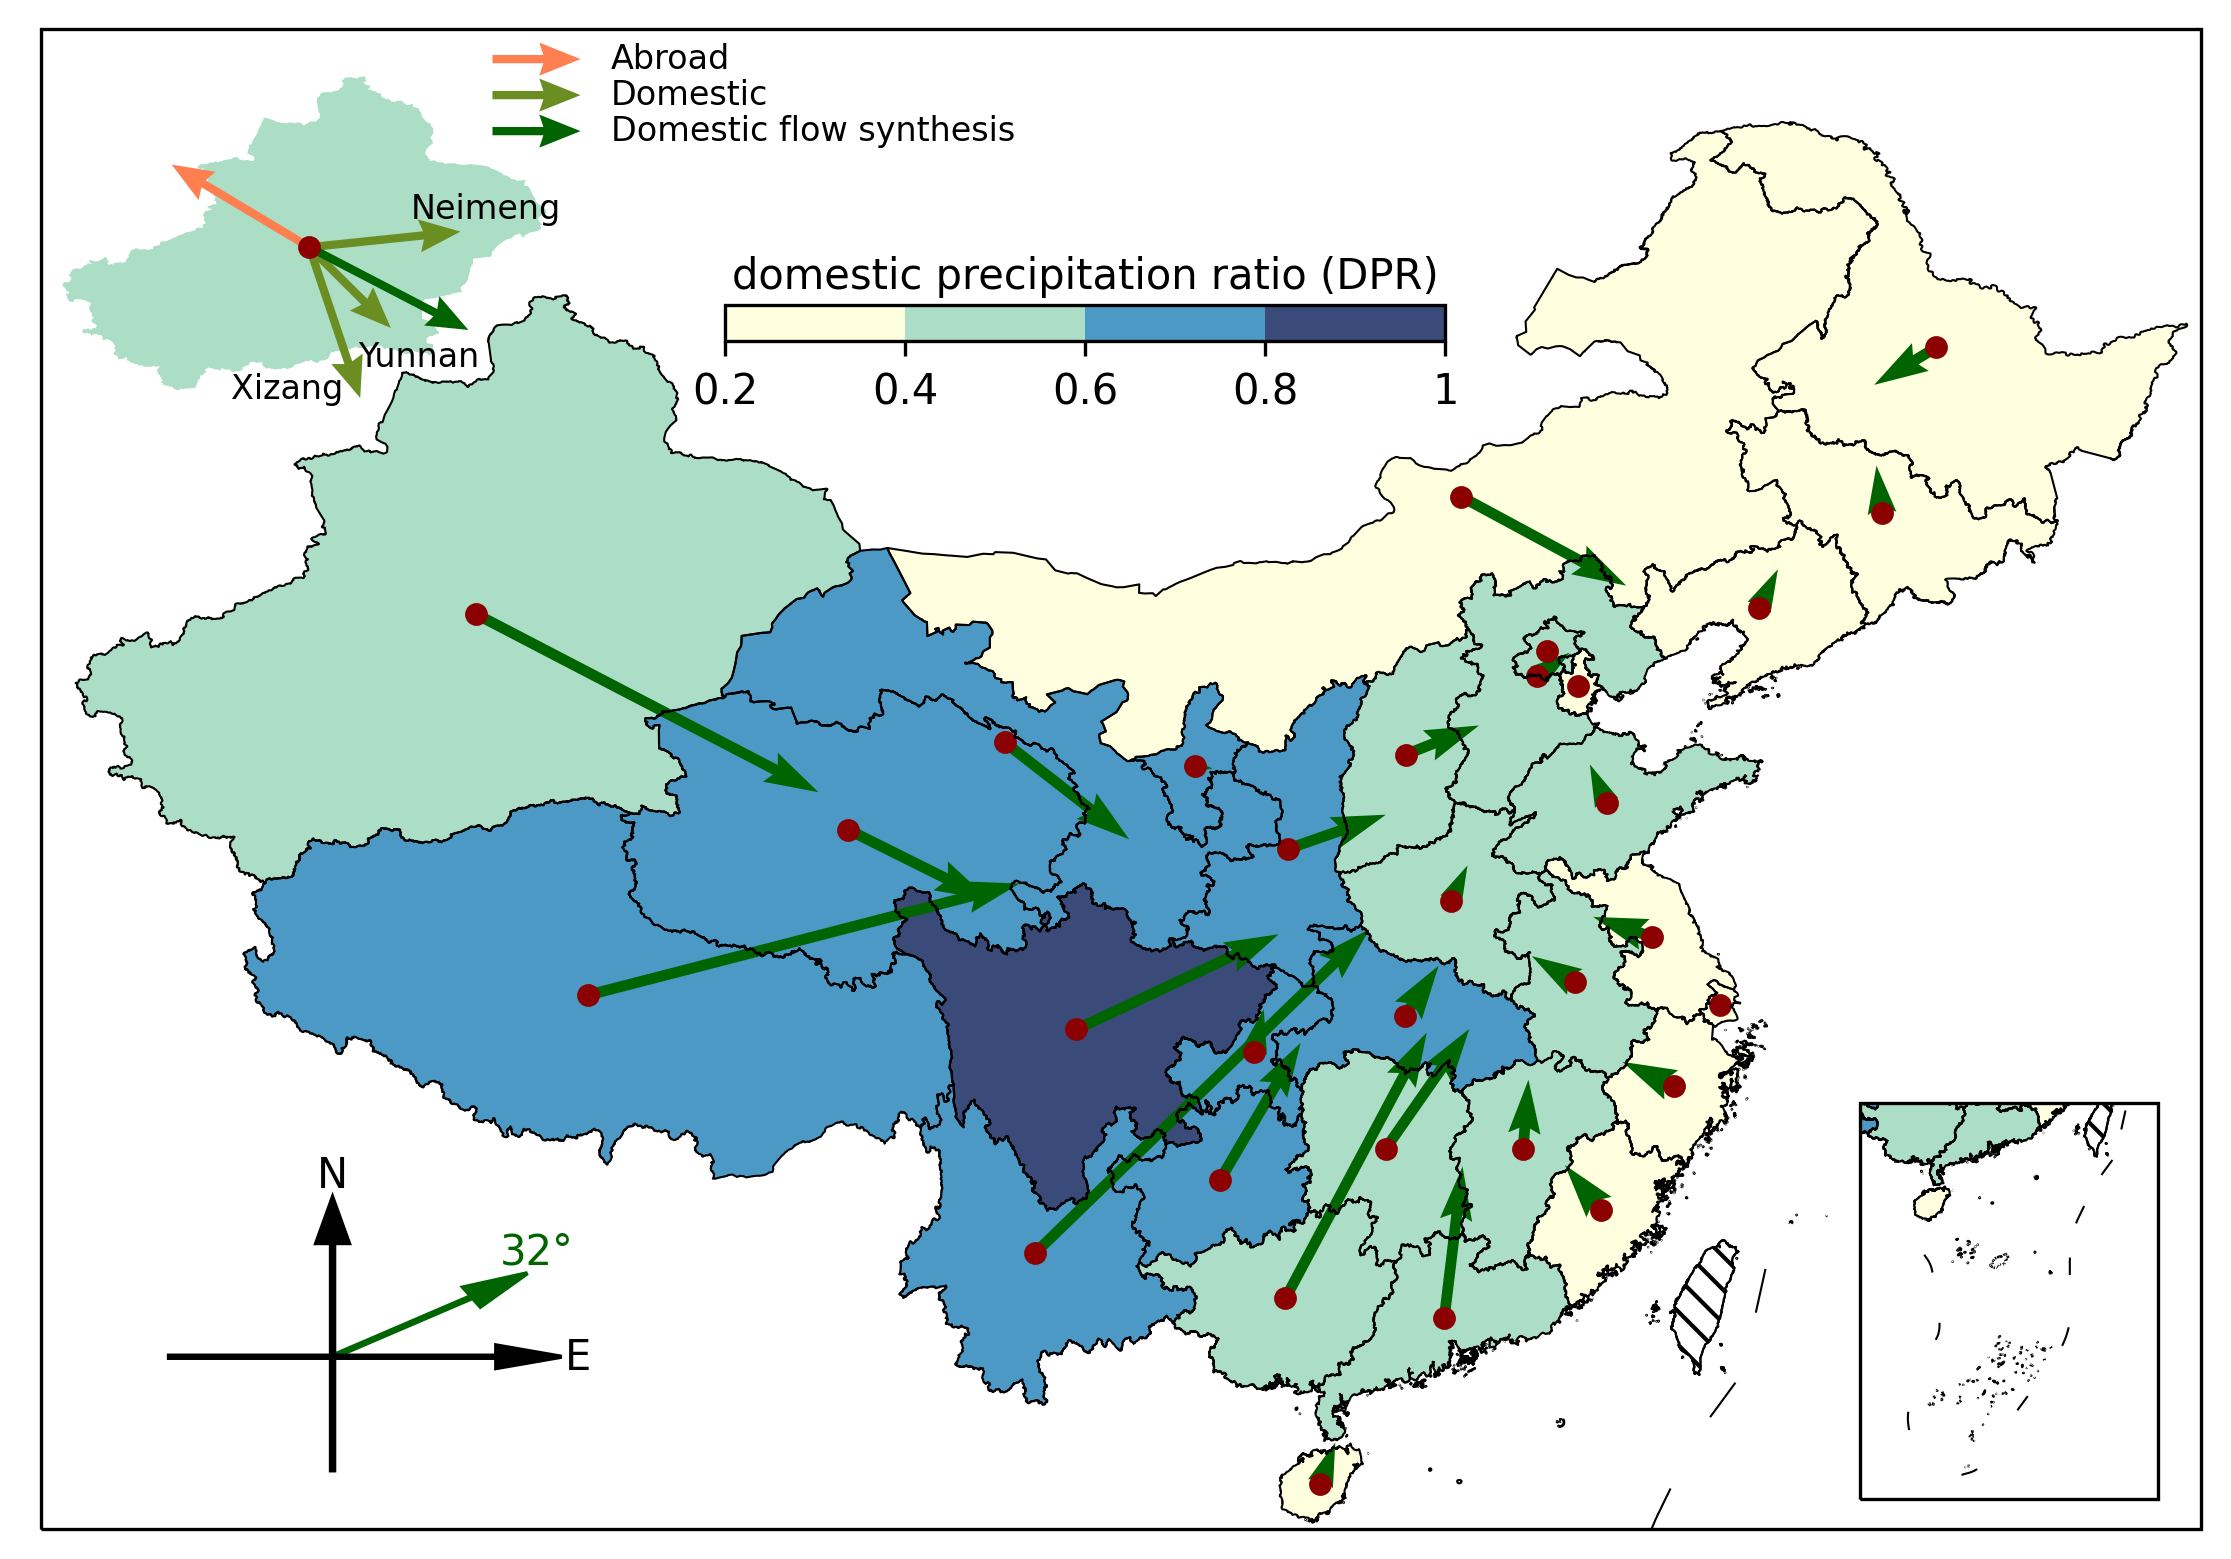

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.cm as cm
import cartopy.io.shapereader as shpreader
import math
import matplotlib.colors as mcolors

# get provincial list with x and y information
def get_pro_list():
    # contains location (x,y) of each province in China
    pro_xy=pd.read_csv('../data/society/china_province_center_point.csv')
    # expand origional province list to include xy
    pro_list=pd.read_csv('../data/society/china_province_list.csv')
    pro_xy.rename(columns={'省代码':'id'},inplace=True)
    pro_list = pro_list.merge(pro_xy,on='id').set_index('id')
    return pro_list

# calculate moisture transfer direction at provincial level along x and y direction
# type: source means the direction at source region
def calculate_moisture_transfer_direction(type='source'):
    pro_list=get_pro_list()
    if type=='source':
        # load provincial precipitation contribution results
        # dpc=pd.read_csv('../data/ET&pre/pre_target_tp_0601.csv').set_index('name')
        # dpc=pd.read_csv('../data/ET&pre/prec_source_zonal0601_tp.csv').set_index('name')
        dpc=pd.read_csv('../data/ET&pre/pre_108m3_target_tp_0601.csv').set_index('name')
    # create x and y direction ratio following the format of precipitation contribution
    x_div=dpc.copy()
    y_div=dpc.copy()
    # Calculate the component raio of transfer between provinces matrics along x and y direction
    # this ratio is to scale z value to x and y directions
    # ignore local to local transfer
    for source in dpc.columns:
        for target in dpc.index:
            source_xy = pro_list.loc[pro_list['name']==source.split('_', 1)[0]][['xcoord','ycoord']].values
            target_xy = pro_list.loc[pro_list['name']==target][['xcoord','ycoord']].values
            diff_xy = (target_xy-source_xy).squeeze()
            x_div.loc[target,source] = diff_xy[0]/((diff_xy[0]**2+diff_xy[1]**2)**0.5)
            y_div.loc[target,source] = diff_xy[1]/((diff_xy[0]**2+diff_xy[1]**2)**0.5)
    return x_div, y_div

def calculate_angle(x, y):
    anglead = math.atan(y / x) 
    angle_deg = math.degrees(anglead)
    return angle_deg

def chinap_code(shp_path,data_value):
    shp_data = gpd.read_file(shp_path)
    pro_info= pd.read_csv('../data/society/china_province_center_point.csv')
    pro_code = pro_info.iloc[:,0]
    data_df = pd.concat([pro_code,data_value],axis = 1,ignore_index = True)
    data_df = data_df.rename(columns={0: "省代码",1: "datavalue"})
    pic_data = shp_data.merge(data_df, on='省代码')
    return pic_data

x_div,y_div = calculate_moisture_transfer_direction(type='source')
pro_list = get_pro_list()
pro_list = pro_list.iloc[0:31,:]
# load provincial precipitation contribution results
# dpc=pd.read_csv('../data/ET&pre/pre_target_tp_0601.csv').set_index('name')
# dpc=pd.read_csv('../data/ET&pre/prec_source_zonal0601_tp.csv').set_index('name')
dpc=pd.read_csv('../data/ET&pre/pre_108m3_target_tp_0601.csv').set_index('name')

x_sum = np.array((x_div*dpc).sum()).reshape(31,1)
y_sum = np.array((y_div*dpc).sum()).reshape(31,1)

# flow of total provinces
angle = calculate_angle(x_sum.sum(), y_sum.sum())

# calculate ET form pre in domestic ratio
data_pre_relative = pd.read_csv('../data/ET&pre/prec_source_zonal0601.csv')
pro_ETpre_relative = np.array(data_pre_relative.iloc[0:31,1:32])
data_h = pd.read_csv('../data/society/GDP&waterwithdrawal.csv')
ET_data = pd.read_csv('../data/ET&pre/et_zonal_ERA5.csv')
# unit km3
pro_pre_km3_total = np.array(data_h['average_pre(108m3)']).reshape((1,31))/10
# pre formed ET (km3)
pro_ETpre_km3 = pro_ETpre_relative * pro_pre_km3_total
# domestic pre by ET
pro_ETpre_km3_sum  =pro_ETpre_km3.sum(axis=1)
ET_in_dom_ratio = pro_ETpre_km3_sum / (ET_data['et'].values * data_h['area(km2)'].values / 1000000)
ET_in_dom_ratio = pd.DataFrame(ET_in_dom_ratio)

# plot
def flow_plot(ax,axx,chinap_shp,NH_shp,TXA_shp):
    ax.set_extent([72.5, 135.5, 18, 52], ccrs.Geodetic())
    ax.add_geometries(shpreader.Reader(chinap_shp).geometries(),crs=ccrs.PlateCarree(),facecolor='none', lw=0.5,alpha=1)
    # Nanhai & taiwan, hongkong, Macao
    ax.add_geometries(shpreader.Reader(NH_shp).geometries(),\
                        crs = ccrs.PlateCarree(),facecolor = 'None',lw = 0.5,alpha = 1)
    ax.add_geometries(shpreader.Reader(TXA_shp).geometries(),crs=ccrs.PlateCarree(),\
                        facecolor='none',hatch='\\\\\\',lw=0.5,alpha = 1)

    china_data = chinap_code(chinap_shp,ET_in_dom_ratio)
    bins = [0.2, 0.4, 0.6, 0.8, 1]
    nbin = len(bins) - 1
    cmap = cm.get_cmap('YlGnBu', nbin)
    norm = mcolors.BoundaryNorm(bins, nbin)
    china_data.plot(column='datavalue', cmap=cmap, linewidth=0.5, ax=ax, alpha=0.8, norm = norm)
    sm = plt.cm.ScalarMappable(norm, cmap)
    cax = fig.add_axes([ax.get_position().xmin+1/2*ax.get_position().width-0.11,ax.get_position().ymax-0.13,0.2,0.015])
    cbar = fig.colorbar(sm,cax=cax, orientation='horizontal', alpha = 0.8)
    cbar.ax.tick_params(labelsize=10) 
    cbar.set_ticks(bins)
    cbar.set_ticklabels(bins)
    cbar.set_label('domestic precipitation ratio (DPR)')
    cbar.ax.xaxis.set_label_position('top')

    colors_array = np.zeros((nbin, 3), dtype=int)
    for i in range(nbin):
        color = cmap(i / (nbin - 1))
        colors_array[i] = np.array(color[:3]) * 255

    ax.quiver(pro_list['xcoord'], pro_list['ycoord'], (x_div*dpc).sum(), (y_div*dpc).sum(), transform=ccrs.PlateCarree(), width =0.005, color='darkgreen')
    ax.scatter(pro_list['xcoord'], pro_list['ycoord'], c= 'darkred', s=20)

    axx.add_geometries(shpreader.Reader(chinap_shp).geometries(),crs=ccrs.PlateCarree(),facecolor='none', lw=0.5,alpha=1)
    axx.add_geometries(shpreader.Reader(NH_shp).geometries(),crs=ccrs.PlateCarree(),facecolor='none', lw=0.5,alpha=1)
    axx.add_geometries(shpreader.Reader(TXA_shp).geometries(),crs=ccrs.PlateCarree(),facecolor='none', hatch='\\\\\\',lw=0.5,alpha=1) 
    axx.set_extent([105, 125, 2, 25])
    china_data.plot(column='datavalue', cmap=cmap, linewidth=0.5, ax=axx, alpha=0.8, norm = norm)

    return colors_array

def arrow_total(ax, angle):
    length = 0.05
    anglead = angle * (3.14159 / 180)
    end_x = length * math.cos(anglead)
    end_y = length * math.sin(anglead)
    ax.arrow(0, 0, end_x, end_y, head_width=0.01, head_length=0.02, fc='darkgreen', ec='darkgreen')
    ax.arrow(-0.05, 0, 0.1, 0, head_width=0.01, head_length=0.02, fc='black', ec='black')
    ax.arrow(0, -0.05, 0, 0.1, head_width=0.01, head_length=0.02, fc='black', ec='black')
    ax.text(0.075, 0, 'E', fontsize=10, horizontalalignment='center', verticalalignment='center')
    ax.text(0, 0.08, 'N', fontsize=10, horizontalalignment='center', verticalalignment='center')
    ax.text(end_x+0.02, end_y+0.02, f'{int(round(angle,0))}\u00B0', color = 'darkgreen',fontsize=10, horizontalalignment='center', verticalalignment='center')
    ax.axis('off')

def quiver_explain(ax, colors_array, xinjiang_shp):

    def quiver_data_single(ax,a,b,scale):
        xj_o_dpc = dpc.iloc[a,b]
        xj_o_x_div = x_div.iloc[a,b]
        xj_o_y_div = y_div.iloc[a,b]
        xj_o_x_sum = xj_o_x_div * xj_o_dpc
        xj_o_y_sum = xj_o_y_div * xj_o_dpc
        Q3 = ax.quiver(xj_xy['xcoord'], xj_xy['ycoord'], xj_o_x_sum, xj_o_y_sum, transform=ccrs.PlateCarree(), 
                width =0.015, headwidth = 4,scale = scale, color='olivedrab', zorder=9)
        return Q3

    xj_x_sum = (x_div*dpc).sum().iloc[-1]
    xj_y_sum = (y_div*dpc).sum().iloc[-1]
    xj_xy = pro_list[pro_list['name'] == 'Xinjiang']
    ax.set_extent([72, 98, 33, 50], crs=ccrs.PlateCarree())
    ax.add_geometries(shpreader.Reader(xinjiang_shp).geometries(), crs=ccrs.PlateCarree(), 
                      facecolor=(colors_array[1,0]/255,colors_array[1,1]/255,colors_array[1,2]/255), lw=1, alpha=0.8)
    ax.scatter(xj_xy['xcoord'], xj_xy['ycoord'], c= 'darkred', s=20, zorder=11)
    Q1 = ax.quiver(xj_xy['xcoord'], xj_xy['ycoord'], -50, 30, transform=ccrs.PlateCarree(), width =0.015, headwidth = 4, scale = 200, color='coral',zorder=9)
    # ax.quiver(xj_xy['xcoord'], xj_xy['ycoord'], -50, -30, transform=ccrs.PlateCarree(), width =0.015, headwidth = 4, scale = 200, color='coral',zorder=9)
    # ax.quiver(xj_xy['xcoord'], xj_xy['ycoord'], -50, 250, transform=ccrs.PlateCarree(), width =0.015, headwidth = 4, scale = 1000, color='coral',zorder=9)
    Q2 = ax.quiver(xj_xy['xcoord'], xj_xy['ycoord'], xj_x_sum, xj_y_sum, transform=ccrs.PlateCarree(), width =0.015, headwidth = 4, scale = 3000, color='darkgreen', zorder=10)
    Q3 = quiver_data_single(ax,4,-1,500)
    quiver_data_single(ax,24,-1,3)
    quiver_data_single(ax,25,-1,1000)
    ax.quiverkey(Q1, 1, 1 ,32 ,'Abroad', labelpos = 'E',fontproperties={'size': 8})
    ax.quiverkey(Q3, 1, 0.9 ,80 ,'Domestic', labelpos = 'E',fontproperties={'size': 8})
    ax.quiverkey(Q2, 1, 0.8 ,480 ,'Domestic flow synthesis', labelpos = 'E',fontproperties={'size': 8})
    # ax.text(75,48,'Ignore abroad',fontsize='8')
    ax.text(90,42.5,'Neimeng',fontsize='8')
    ax.text(87.5,35.5,'Yunnan',fontsize='8')
    ax.text(81.5,34,'Xizang',fontsize='8')
    for spine in ax.spines.values():
        spine.set_color('none')
    ax.set_facecolor('none')

chinap_shp = r'D:/1Important Work/CODE summarizing/picture shp/China_shp/china_province.shp'
NH_shp = r'D:/1Important Work/CODE summarizing/picture shp/China_shp/NH_boundary.shp'
TXA_shp = r'D:/1Important Work/CODE summarizing/picture shp/China_shp/TW&HK$AM_province.shp'
xinjiang_shp = r'D:/1Important Work/CODE summarizing/picture shp/China_shp/xinjiang_g.shp'

fig = plt.figure(figsize=(12, 8),dpi=300)
ax = fig.add_axes([0,0,0.6,0.8],projection=ccrs.PlateCarree())
ax2 = fig.add_axes([ax.get_position().xmax-0.08, ax.get_position().ymin+0.1, 0.12, 0.165], projection=ccrs.PlateCarree())
ax3 = ax.inset_axes([0.05, 0.03, 0.2, 0.2], transform=ax.transAxes)
ax4 = fig.add_axes([ax.get_position().xmin-0.26, ax.get_position().ymax-0.25, 0.6, 0.15], projection=ccrs.PlateCarree())

colors_array = flow_plot(ax,ax2,chinap_shp,NH_shp,TXA_shp)
arrow_total(ax3,angle)
quiver_explain(ax4,colors_array,xinjiang_shp)


In [5]:
import pandas as pd
import numpy as np


def social_economic_data():

    data_preelative = pd.read_csv('../data/ET&pre/prec_source_zonal0601.csv')
    pro_ETpreelative = data_preelative.iloc[0:31,1:32].values
    data_h = pd.read_csv('../data/society/GDP&waterwithdrawal.csv')
    pro_name_list = data_h['province'].values.reshape(31,1)

    # unit km3
    pro_ETsur_km3 = pro_ETpreelative * data_h['average_surface_water_resources(108m3)'].values.reshape((1,31))/10
    pro_ETsur_km3_sum = pro_ETsur_km3.sum(axis=1).reshape(31,1)

    # unit billion rmb
    pro_ETGDP = pro_ETpreelative * data_h['sum_GDP_2020RMB(108)'].values.reshape((1,31))/10
    pro_ETGDP_sum = pro_ETGDP.sum(axis=1).reshape(31,1)

    pro_ETagr = pro_ETpreelative * data_h['agr_GDP_2020RMB(108)'].values.reshape((1,31))/10
    pro_ETagr_sum = pro_ETagr.sum(axis=1).reshape(31,1)
    pro_ETind = pro_ETpreelative * data_h['ind_GDP_2020RMB(108)'].values.reshape((1,31))/10
    pro_ETind_sum = pro_ETind.sum(axis=1).reshape(31,1)
    pro_ETser = pro_ETpreelative * data_h['ser_GDP_2020RMB(108)'].values.reshape((1,31))/10
    pro_ETser_sum = pro_ETser.sum(axis=1).reshape(31,1)

    # unit million pop
    pro_ETpop = pro_ETpreelative * data_h['population(wanren)'].values.reshape((1,31))/100
    pro_ETpop_sum = pro_ETpop.sum(axis=1).reshape(31,1)
    # unit million ton
    pro_ETfood = pro_ETpreelative * data_h['food_production(wan_t)'].values.reshape((1,31))/100
    pro_ETfood_sum = pro_ETfood.sum(axis=1).reshape(31,1)

    return pro_name_list,pro_ETsur_km3_sum,pro_ETGDP_sum,pro_ETagr_sum,pro_ETind_sum,pro_ETser_sum,pro_ETpop_sum,pro_ETfood_sum

pro_name_list,pro_ETsur_km3_sum,pro_ETGDP_sum,pro_ETagr_sum,pro_ETind_sum,pro_ETser_sum,pro_ETpop_sum,pro_ETfood_sum = social_economic_data()

data_value = np.concatenate((pro_name_list,pro_ETsur_km3_sum,pro_ETGDP_sum,pro_ETagr_sum,pro_ETind_sum,pro_ETser_sum,pro_ETpop_sum,pro_ETfood_sum),axis=1)

col_list = ['name','surface water','GDP','agr','ind','ser','pop','food']

data_value = pd.DataFrame(data_value)
data_value.columns=col_list
data_value.to_csv('../data/society/embody_socioeco_value.csv',encoding='utf-8')

0.3970688341871119
0.44956792368630527
0.46323601332681835
0.4961558832383436


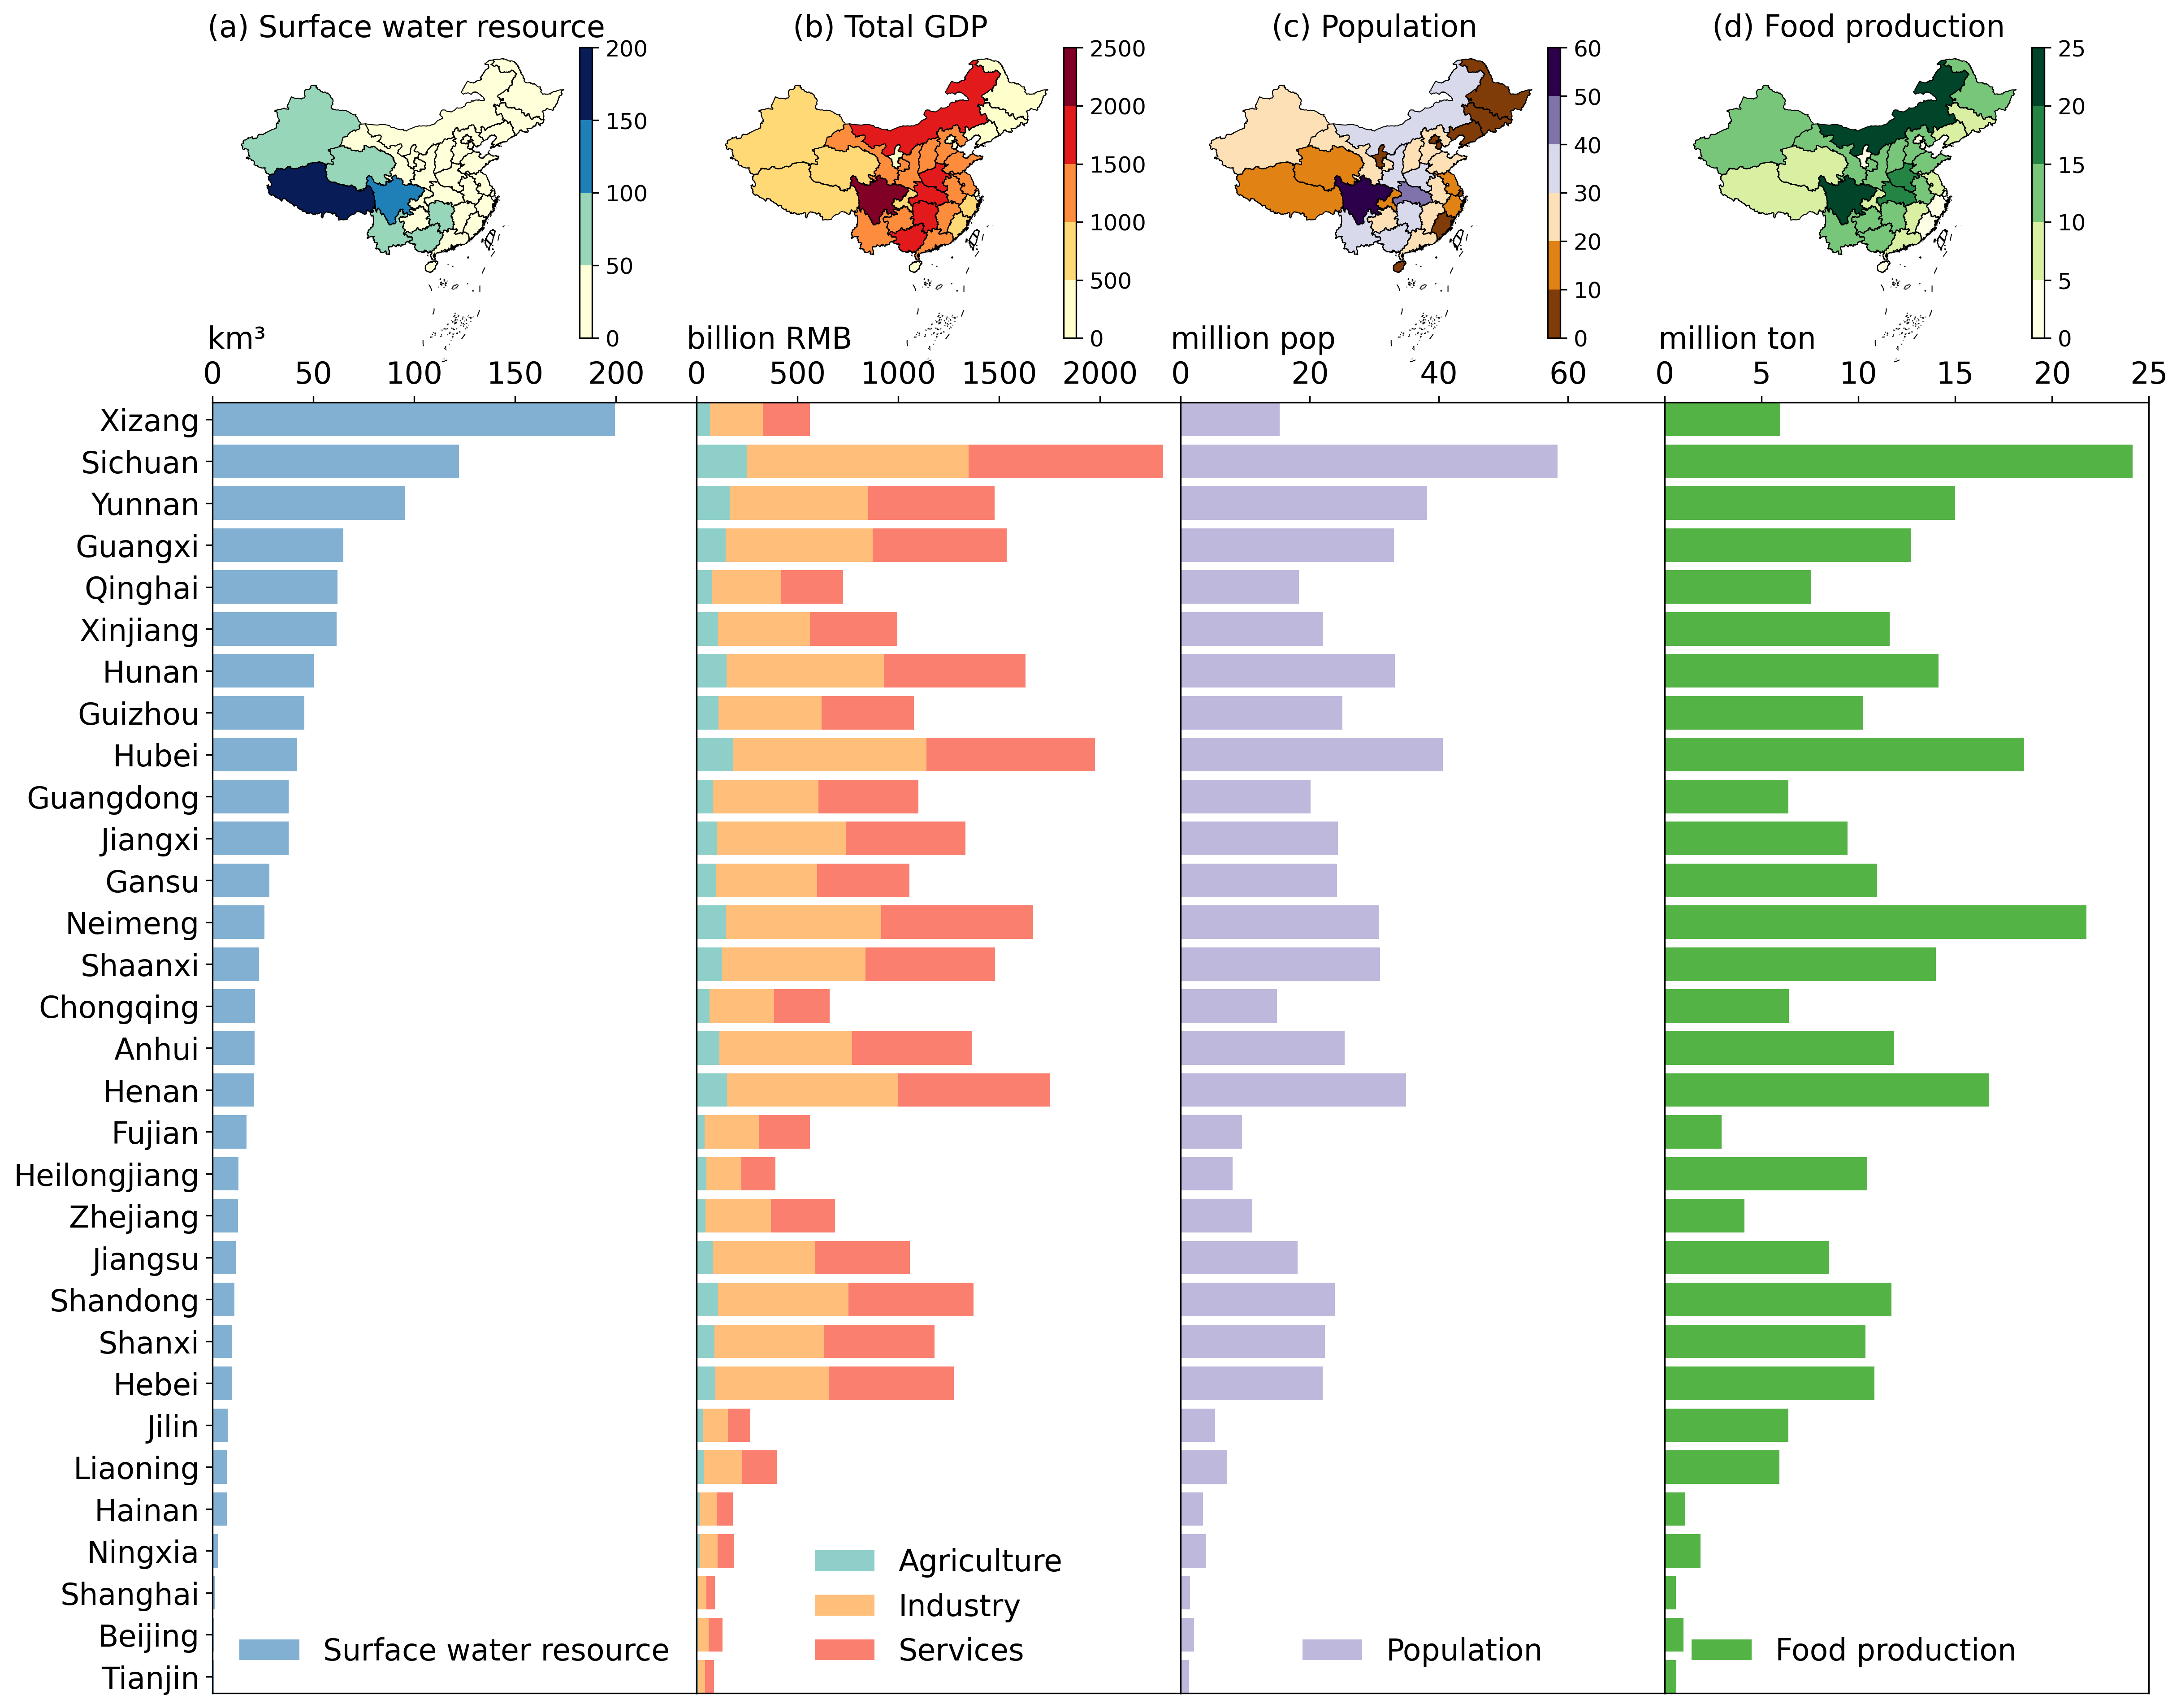

In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader

def social_economic_data_sort():

    data_preelative = pd.read_csv('../data/ET&pre/prec_source_zonal0601.csv')
    pro_ETpreelative = data_preelative.iloc[0:31,1:32].values
    data_h = pd.read_csv('../data/society/GDP&waterwithdrawal.csv')
    pro_name_list = data_h['province'].tolist()

    # unit km3
    pro_ETsur_km3 = pro_ETpreelative * data_h['average_surface_water_resources(108m3)'].values.reshape((1,31))/10
    pro_ETsur_km3_sum = pro_ETsur_km3.sum(axis=1)
    print (pro_ETsur_km3_sum.sum()/(data_h['average_surface_water_resources(108m3)'].values.reshape((1,31))/10).sum())

    # unit billion rmb
    pro_ETGDP = pro_ETpreelative * data_h['sum_GDP_2020RMB(108)'].values.reshape((1,31))/10
    pro_ETGDP_sum = pro_ETGDP.sum(axis=1)
    print (pro_ETGDP_sum.sum()/(data_h['sum_GDP_2020RMB(108)'].values.reshape((1,31))/10).sum())

    pro_ETagr = pro_ETpreelative * data_h['agr_GDP_2020RMB(108)'].values.reshape((1,31))/10
    pro_ETagr_sum = pro_ETagr.sum(axis=1)
    pro_ETind = pro_ETpreelative * data_h['ind_GDP_2020RMB(108)'].values.reshape((1,31))/10
    pro_ETind_sum = pro_ETind.sum(axis=1)
    pro_ETser = pro_ETpreelative * data_h['ser_GDP_2020RMB(108)'].values.reshape((1,31))/10
    pro_ETser_sum = pro_ETser.sum(axis=1)

    # unit million pop
    pro_ETpop = pro_ETpreelative * data_h['population(wanren)'].values.reshape((1,31))/100
    pro_ETpop_sum = pro_ETpop.sum(axis=1)
    print (pro_ETpop_sum.sum()/(data_h['population(wanren)'].values.reshape((1,31))/100).sum())

    # unit million ton
    pro_ETfood = pro_ETpreelative * data_h['food_production(wan_t)'].values.reshape((1,31))/100
    pro_ETfood_sum = pro_ETfood.sum(axis=1)
    print (pro_ETfood_sum.sum()/(data_h['food_production(wan_t)'].values.reshape((1,31))/100).sum())

    # sort
    sorted_index_S = np.argsort(pro_ETsur_km3_sum)[::-1]
    pro_ETsur_km3_sum_sort = pro_ETsur_km3_sum[sorted_index_S]
    pro_name_list_sort_s = np.array(pro_name_list)[sorted_index_S]

    pro_ETGDP_sum_sort = pro_ETGDP_sum[sorted_index_S]
    pro_name_list_sort_E = np.array(pro_name_list)[sorted_index_S]

    pro_ETpop_sum_sort = pro_ETpop_sum[sorted_index_S]

    pro_ETfood_sum_sort = pro_ETfood_sum[sorted_index_S]

    return (pro_ETsur_km3_sum,pro_ETGDP_sum,pro_ETpop_sum,pro_ETfood_sum,pro_ETagr_sum,pro_ETind_sum,
            pro_ETser_sum,pro_ETsur_km3_sum_sort,pro_name_list_sort_s,pro_ETGDP_sum_sort,pro_name_list_sort_E,
            sorted_index_S,pro_ETpop_sum_sort,pro_ETfood_sum_sort)

def chinap_code(shp_path,data_value):
    shp_data = gpd.read_file(shp_path)
    pro_info = pd.read_csv('../data/society/china_province_center_point.csv')
    data_df = pd.concat([pro_info.iloc[:,0],data_value],axis = 1,ignore_index = True)
    data_df = data_df.rename(columns={0: "省代码",1: "datavalue"})
    pic_data = shp_data.merge(data_df, on='省代码')
    return pic_data

def barh_plot(ax,pro_name_list_sort,data_sort,label,color,legloc,xlabel):
    ax.barh(np.arange(len(pro_name_list_sort)), data_sort, label=label,height=0.8,color=color)
    ax.xaxis.tick_top()
    ax.margins(y=0.0)
    ax.set_yticks(range(len(pro_name_list_sort)))
    ax.set_yticklabels(pro_name_list_sort_s.tolist())
    ax.invert_yaxis()
    ax.legend(loc=legloc, prop={'size': 16}, frameon=False)
    ax.set_xlabel(xlabel,fontsize = 16)
    ax.xaxis.set_label_coords(0.15, 1.06)
    ax.tick_params(axis='both', labelsize=16)


def China_map_plot(ax,chinap_shp,NH_shp,TXA_shp,data_vlaue,bins,colorbar,title):
    axx = fig.add_axes([ax.get_position().x0-0.03, ax.get_position().y1+0.02, ax.get_position().width, 0.2],projection=ccrs.PlateCarree(),frameon=False)
    axx.add_geometries(shpreader.Reader(chinap_shp).geometries(),crs=ccrs.PlateCarree(),facecolor='none', lw=0.5,alpha=1)
    axx.add_geometries(shpreader.Reader(NH_shp).geometries(),\
                        crs = ccrs.PlateCarree(),facecolor = 'None',lw = 0.5,alpha = 1)
    axx.add_geometries(shpreader.Reader(TXA_shp).geometries(),crs=ccrs.PlateCarree(),facecolor='none', hatch='\\\\\\\\',lw=0.5,alpha=1) 
    axx.set_extent([70, 140, 2, 50],ccrs.Geodetic())
    axx.set_title(title,fontsize = 16)

    china_data = chinap_code(chinap_shp,pd.DataFrame(data_vlaue))
    nbin = len(bins) - 1
    cmap = plt.cm.get_cmap(colorbar, nbin)
    norm = mcolors.BoundaryNorm(bins, nbin)
    china_data.plot(column='datavalue', cmap=cmap, linewidth=0.5, ax=axx, alpha=1, norm = norm)
    sm = plt.cm.ScalarMappable(norm, cmap)
    cax = fig.add_axes([ax.get_position().x0+axx.get_position().width, ax.get_position().y1+0.04, 0.008, axx.get_position().height-0.02])
    cbar = fig.colorbar(sm,cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12) 
    cbar.set_ticks(bins)
    cbar.set_ticklabels(bins)


chinap_shp = r'D:/1Important Work/CODE summarizing/picture shp/China_shp/china_province.shp'
NH_shp = r'D:/1Important Work/CODE summarizing/picture shp/China_shp/NH_boundary.shp'
TXA_shp = r'D:/1Important Work/CODE summarizing/picture shp/China_shp/TW&HK$AM_province.shp'

(pro_ETsur_km3_sum,pro_ETGDP_sum,pro_ETpop_sum,pro_ETfood_sum,pro_ETagr_sum,pro_ETind_sum,pro_ETser_sum,pro_ETsur_km3_sum_sort,pro_name_list_sort_s,\
pro_ETGDP_sum_sort,pro_name_list_sort_E,sorted_index_S,pro_ETpop_sum_sort,pro_ETfood_sum_sort) = social_economic_data_sort()

fig= plt.figure(figsize=(12, 12), dpi=300)
ax1 = fig.add_axes([0, 0, 0.3, 0.8])
ax1.yaxis.tick_left()
ax1.set_xlim(0,240)
barh_plot(ax1,pro_name_list_sort_s,pro_ETsur_km3_sum_sort,'Surface water resource','#82B0D2','lower left','km\u00B3')
China_map_plot(ax1,chinap_shp,NH_shp,TXA_shp,pro_ETsur_km3_sum,[0, 50, 100, 150, 200],'YlGnBu','(a) Surface water resource')
ax1.xaxis.set_label_coords(0.05, 1.06)

def ax2_plot(ax2):
    labellist2 = ['Agriculture', 'Industry', 'Services']
    colorlist2 = ['#8ECFC9', '#FFBE7A', '#FA7F6F']
    ET_embodied_GDP = np.concatenate((pro_ETagr_sum.reshape(31,1),pro_ETind_sum.reshape(31,1),pro_ETser_sum.reshape(31,1)),axis=1)
    sum_values2 = np.zeros(len(pro_name_list_sort_s))
    for i in range(ET_embodied_GDP.shape[1]):
        sorted_data2 = ET_embodied_GDP[:,i][sorted_index_S]
        ax2.barh(pro_name_list_sort_s, sorted_data2, label=labellist2[i], color=colorlist2[i], alpha=1, left=sum_values2, height=0.8)
        sum_values2 += sorted_data2

    ax2.xaxis.tick_top()
    ax2.margins(y=0.0)
    ax2.get_yaxis().set_visible(False)
    ax2.invert_yaxis()
    ax2.set_xlim(0,2400)
    ax2.legend(loc='lower center', prop={'size': 16}, frameon=False)
    ax2.set_xlabel('billion RMB',fontsize = 16)
    ax2.xaxis.set_label_coords(0.15, 1.06)
    ax2.set_xticks([0,500,1000,1500,2000])
    ax2.tick_params(axis='both', labelsize=16)

ax2 = fig.add_axes([0.3,0,0.3,0.8])
ax2_plot(ax2)
China_map_plot(ax2,chinap_shp,NH_shp,TXA_shp,pro_ETGDP_sum,[0, 500, 1000, 1500, 2000, 2500],'YlOrRd','(b) Total GDP')

ax3 = fig.add_axes([0.6,0,0.3,0.8])
ax3.get_yaxis().set_visible(False)
ax3.set_xlim(0,75)
barh_plot(ax3,pro_name_list_sort_s,pro_ETpop_sum_sort,'Population','#BEB8DC','lower center','million pop')
China_map_plot(ax3,chinap_shp,NH_shp,TXA_shp,pro_ETpop_sum,[0, 10, 20, 30, 40, 50, 60],'PuOr','(c) Population')

ax4 = fig.add_axes([0.9,0,0.3,0.8])
ax4.get_yaxis().set_visible(False)
ax4.set_xlim(0,25)
barh_plot(ax4,pro_name_list_sort_s,pro_ETfood_sum_sort,'Food production','#54B345','lower left','million ton')
China_map_plot(ax4,chinap_shp,NH_shp,TXA_shp,pro_ETfood_sum,[0, 5, 10, 15, 20, 25],'YlGn','(d) Food production')

6.422478144777868
5.287497252607288
177.2037598872103
159.40575176997135
65.35163285604874
57.9115108619034


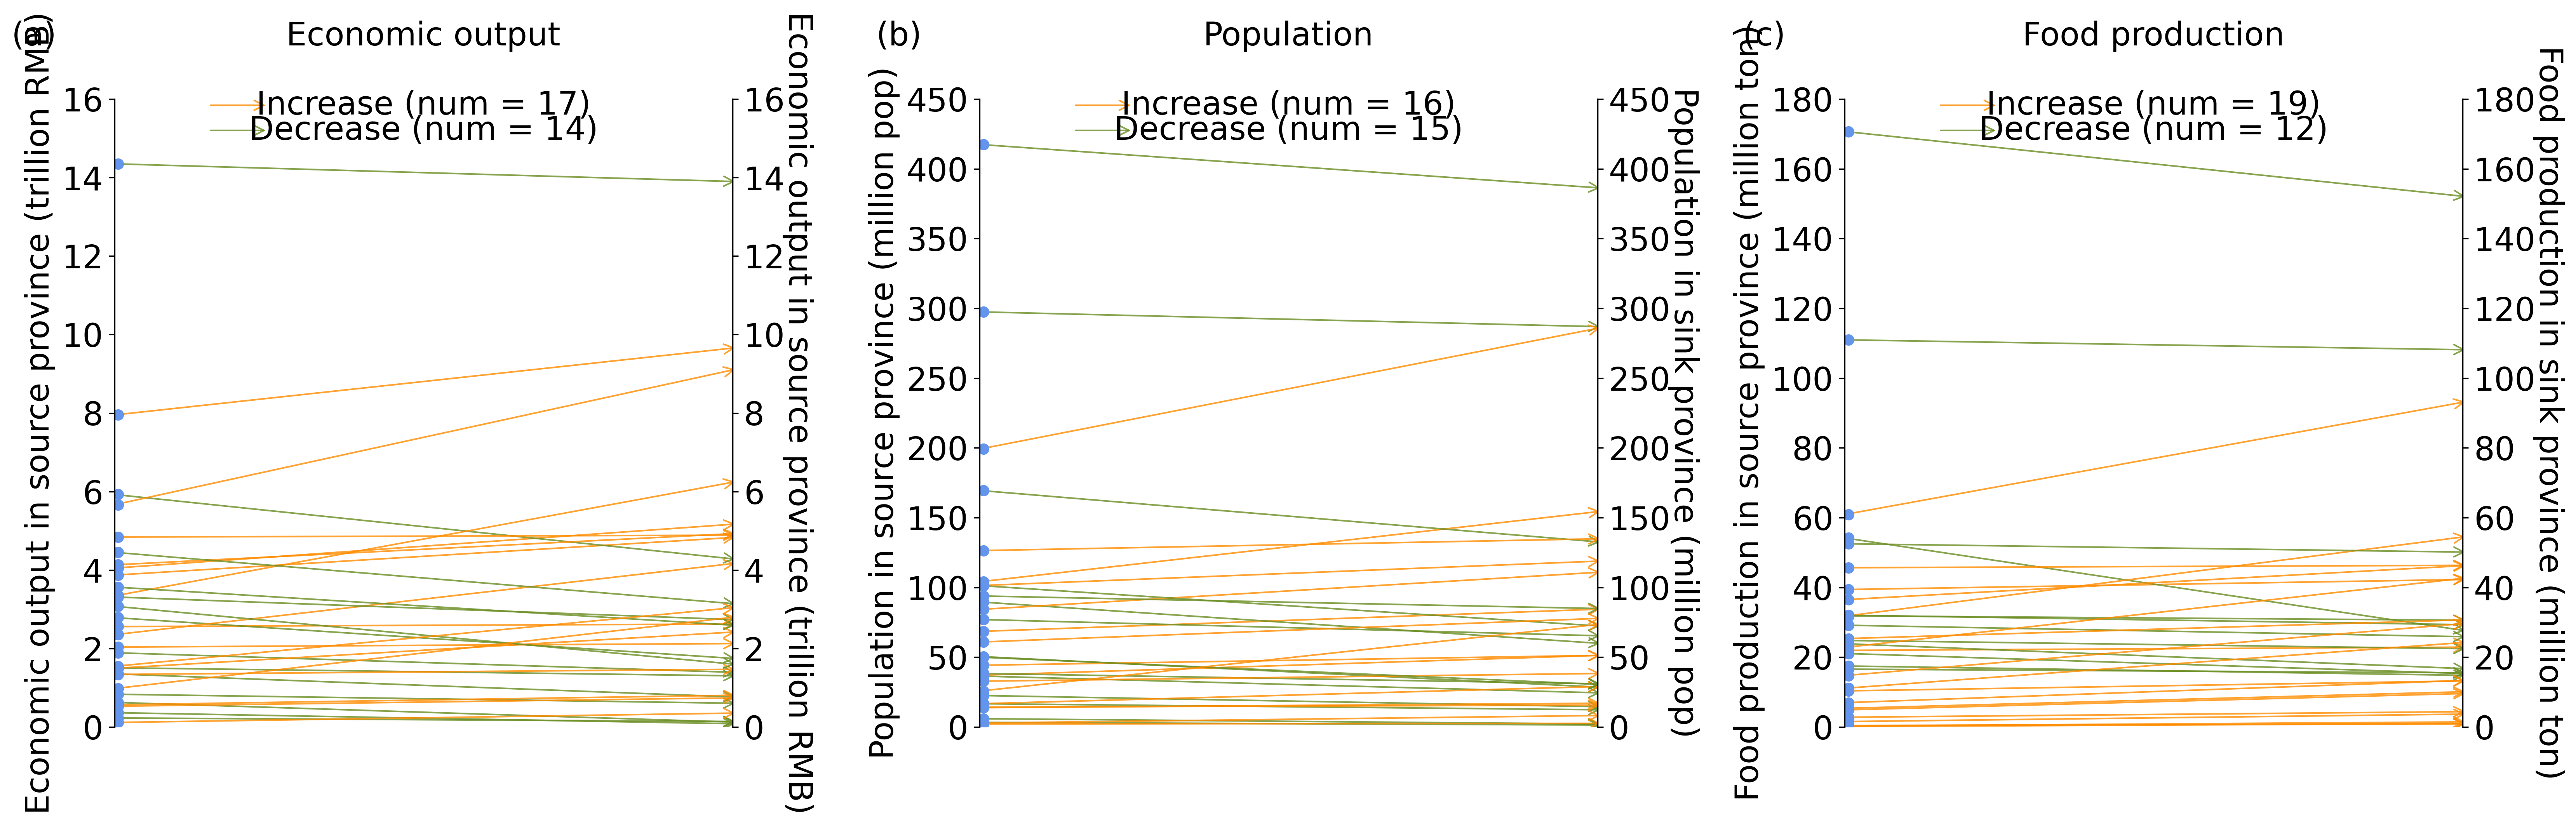

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

def arrow_data(unit_data,m):   
    data_h = pd.read_csv('../data/society/GDP&waterwithdrawal.csv')
    data_preelative = pd.read_csv('../data/ET&pre/prec_source_zonal0601.csv')

    pro_ETpreelative = np.array(data_preelative.iloc[0:31,1:32])
    pro_surwater = np.array(data_h['average_surface_water_resources(108m3)']).reshape((1,31))
    pro_ET_surwater = pro_ETpreelative * pro_surwater
    pro_ET_surwater_sum = pro_ET_surwater.sum(axis=1)

    per_unit_water_socio = np.array(data_h[unit_data]).reshape((1,31))

    # unit adjust
    water_ECOvalue_outerunit = pro_ET_surwater * per_unit_water_socio * m
    water_ECOvalue_innerunit = pro_ET_surwater * per_unit_water_socio.reshape((31,1)) * m

    water_ECOvalue_outerunit_sum = water_ECOvalue_outerunit.sum(axis=1)
    water_ECOvalue_innerunit_sum = water_ECOvalue_innerunit.sum(axis=1)
    water_ECOvalue_outerunit_ave= np.average(water_ECOvalue_outerunit_sum, weights=pro_ET_surwater_sum)
    water_ECOvalue_innerunit_ave = np.average(water_ECOvalue_innerunit_sum, weights=pro_ET_surwater_sum)
    net = water_ECOvalue_outerunit_sum-water_ECOvalue_innerunit_sum
    count = np.sum(net > 0)

    print (water_ECOvalue_outerunit_ave)
    print (water_ECOvalue_innerunit_ave)

    return water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_ave,water_ECOvalue_innerunit_ave,count

def scatter_axes(ax1,ylim,yticks,ylabel1,ylabel2,unit,num):
    ax1.scatter([0.006]*31,water_ECOvalue_innerunit_sum,color='cornflowerblue')
    # ax1.scatter(0,water_ECOvalue_innerunit_ave,color='red',s = 400,alpha=0.5)
    ax1.xaxis.set_visible(False)
    for i in ['top', 'bottom']:
        ax1.spines[i].set_visible(False)
    ax1.set_ylim(0,ylim)
    ax1.set_ylabel(ylabel1,fontsize=20)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.text(-0.13,1.1,unit,transform=ax1.transAxes, fontdict={'size': '20', 'color': 'black'},
                horizontalalignment='center', verticalalignment='center')
    ax1.text(0.5,1.1,num,transform=ax1.transAxes, fontdict={'size': '20', 'color': 'black'},
                horizontalalignment='center', verticalalignment='center')

    ax2 = ax1.twinx()
    ax2.set_xlim([0, 1])
    for i in ['top', 'bottom','left']:
        ax2.spines[i].set_visible(False)
    ax2.set_ylim(0,ylim)
    ax2.set_yticks(yticks)
    ax2.tick_params(axis='both', labelsize=20)
    ax2.set_ylabel(ylabel2,rotation = 270, ha='center', va='center',labelpad=8, fontsize=20)
    # ax2.text(1,1.05,unit,transform=ax1.transAxes, fontdict={'size': '16', 'color': 'black'},
    #         horizontalalignment='center', verticalalignment='center')

def arrow(ax,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_sum,color1,color2,water_ECOvalue_innerunit_ave,water_ECOvalue_outerunit_ave,count,label1,label2,yl1,yl2,ys):
    for d in range(water_ECOvalue_outerunit_sum.shape[0]):
        if water_ECOvalue_outerunit_sum[d] > water_ECOvalue_innerunit_sum[d]:
            color = color1
        else:
            color = color2
        arrow = FancyArrowPatch((0,water_ECOvalue_innerunit_sum[d]), (1.01,water_ECOvalue_outerunit_sum[d]), color=color, arrowstyle='->', 
                                mutation_scale=15, alpha=0.8)
        ax.add_patch(arrow)
    # big arrow
    # arrow_s = FancyArrowPatch((0.01,water_ECOvalue_innerunit_ave), (1.04,water_ECOvalue_outerunit_ave), color='red', arrowstyle='->', 
    #                             mutation_scale=50, alpha=0.5,linewidth = 20)
    # ax.add_patch(arrow_s)

    # legend
    legend1= FancyArrowPatch((0.25,0.99), (0.15,0.99), transform=ax.transAxes, color=color1, arrowstyle='<-', 
                                mutation_scale=15, alpha=0.8)
    ax.add_patch(legend1)
    ax.text(0.5, 0.99, label1+f'Increase (num = {count})', transform=ax.transAxes, ha='center', va='center', fontsize=20)

    legend2= FancyArrowPatch((0.25,0.95), (0.15,0.95), transform=ax.transAxes, color=color2, arrowstyle='<-', 
                                mutation_scale=15, alpha=0.8)
    ax.add_patch(legend2)
    ax.text(0.5, 0.95, label1+f'Decrease (num = {31-count})', transform=ax.transAxes, ha='center', va='center', fontsize=20)
    # big arrow text
    # ax.text(0.5, 0.85, label2 + ' value net flow', transform=ax.transAxes, ha='center', va='center',fontsize=16)

fig = plt.figure(figsize=(26, 7), dpi=300)
plt.subplots_adjust(wspace=0.4)

ax1 = fig.add_subplot(131) 
water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_ave,water_ECOvalue_innerunit_ave,count = arrow_data('per_unit_water_value(rmb_m3)',0.0001)
arrow(ax1,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_sum,'darkorange','olivedrab',
      water_ECOvalue_innerunit_ave,water_ECOvalue_outerunit_ave,count,'','Economic production',15.5,13.8,7)
scatter_axes(ax1,16,[0, 2, 4, 6, 8, 10, 12, 14, 16],
             'Economic output in source province (trillion RMB)','Economic output in source province (trillion RMB)','(a)','Economic output')


ax2 = fig.add_subplot(132) 
water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_ave,water_ECOvalue_innerunit_ave,count = arrow_data('per_unit_water_pop(pop_m3)',100)
arrow(ax2,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_sum,'darkorange','olivedrab',
      water_ECOvalue_innerunit_ave,water_ECOvalue_outerunit_ave,count,'','Population',440,390,200)
scatter_axes(ax2,450,[0, 50, 100, 150, 200, 250, 300, 350, 400, 450],
             'Population in source province (million pop)','Population in sink province (million pop)','(b)','Population')


ax3 = fig.add_subplot(133) 
water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_ave,water_ECOvalue_innerunit_ave,count = arrow_data('per_unit_water_food(ton_m3)',100)
arrow(ax3,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_sum,'darkorange','olivedrab',
      water_ECOvalue_innerunit_ave,water_ECOvalue_outerunit_ave,count,'','Food production',175,155,80)
scatter_axes(ax3,180,[0, 20, 40, 60, 80, 100, 120, 140, 160, 180],
             'Food production in source province (million ton)','Food production in sink province (million ton)','(c)','Food production')


30558.245352705133
26578.986306374223


Text(0.5, 1.1, 'Total net = 3979')

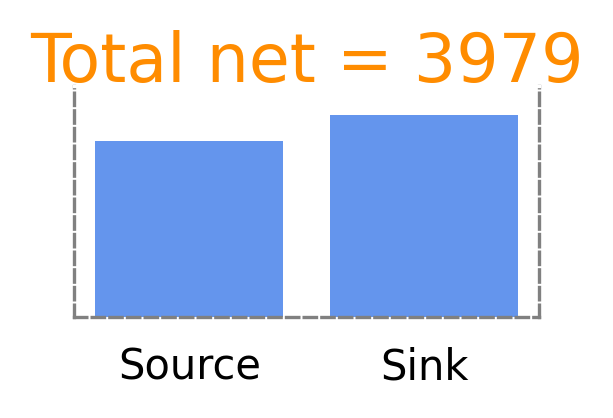

In [73]:
def arrow_data(data,unit_data,m):   
    data_h = pd.read_csv('../data/society/GDP&waterwithdrawal.csv')
    data_preelative = pd.read_csv('../data/ET&pre/prec_source_zonal0601.csv')

    pro_ETpreelative = np.array(data_preelative.iloc[0:31,1:32])
    water_withdrawal = np.array(data_h['sum_water_withdrawal(108m3)']).reshape((1,31))
    socioeconomic_data = np.array(data_h[data]).reshape((1,31))
    per_unit_water_socio = np.array(data_h[unit_data]).reshape((1,31))
    
    # unit adjust
    water_ECOvalue_outerunit = pro_ETpreelative * socioeconomic_data * m
    water_ECOvalue_innerunit = pro_ETpreelative * water_withdrawal * per_unit_water_socio.reshape((31,1)) * m

    water_ECOvalue_outerunit_sum = water_ECOvalue_outerunit.sum(axis=1)
    water_ECOvalue_innerunit_sum = water_ECOvalue_innerunit.sum(axis=1)
    water_ECOvalue_outerunit_total= water_ECOvalue_outerunit_sum.sum()
    water_ECOvalue_innerunit_total = water_ECOvalue_innerunit_sum.sum()
    net = water_ECOvalue_outerunit_sum-water_ECOvalue_innerunit_sum
    count = np.sum(net > 0)

    print (water_ECOvalue_outerunit_total)
    print (water_ECOvalue_innerunit_total)

    return water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_total,water_ECOvalue_innerunit_total,count

water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_total,water_ECOvalue_innerunit_total,count = arrow_data('sum_GDP_2020RMB(108)','per_unit_water_value(rmb_m3)',0.1)

fig = plt.figure(figsize=(2, 1), dpi=300)
ax11 = fig.add_subplot(111)
ax11.bar([1,2],[water_ECOvalue_innerunit_total,water_ECOvalue_outerunit_total],color='cornflowerblue')
ax11.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=True)
ax11.spines['top'].set_linestyle('dashed')
ax11.spines['bottom'].set_linestyle('dashed')
ax11.spines['left'].set_linestyle('dashed')
ax11.spines['right'].set_linestyle('dashed')
ax11.spines['top'].set_color('white')
ax11.spines['right'].set_color('gray')
ax11.spines['bottom'].set_color('gray')
ax11.spines['left'].set_color('gray')
ax11.set_xticks([1, 2])
ax11.set_xticklabels(['Source','Sink'])
ax11.set_ylim([0,35000])
# ax11.text(1,water_ECOvalue_innerunit_total+1000,f'{int(round(water_ECOvalue_innerunit_total,0))}', ha='center', va='center',fontsize=14)
# ax11.text(2,water_ECOvalue_outerunit_total+1000,f'{int(round(water_ECOvalue_outerunit_total,0))}', ha='center', va='center',fontsize=14)
ax11.text(0.5,1.1,f'Total net = {int(round(water_ECOvalue_outerunit_total-water_ECOvalue_innerunit_total,0))}',transform=ax11.transAxes,ha='center', va='center', fontsize=16, color='darkorange')



30558.245352705133
26578.986306374223
629.2760137636167
623.4745268236187
293.68682310791496
268.83652534494854


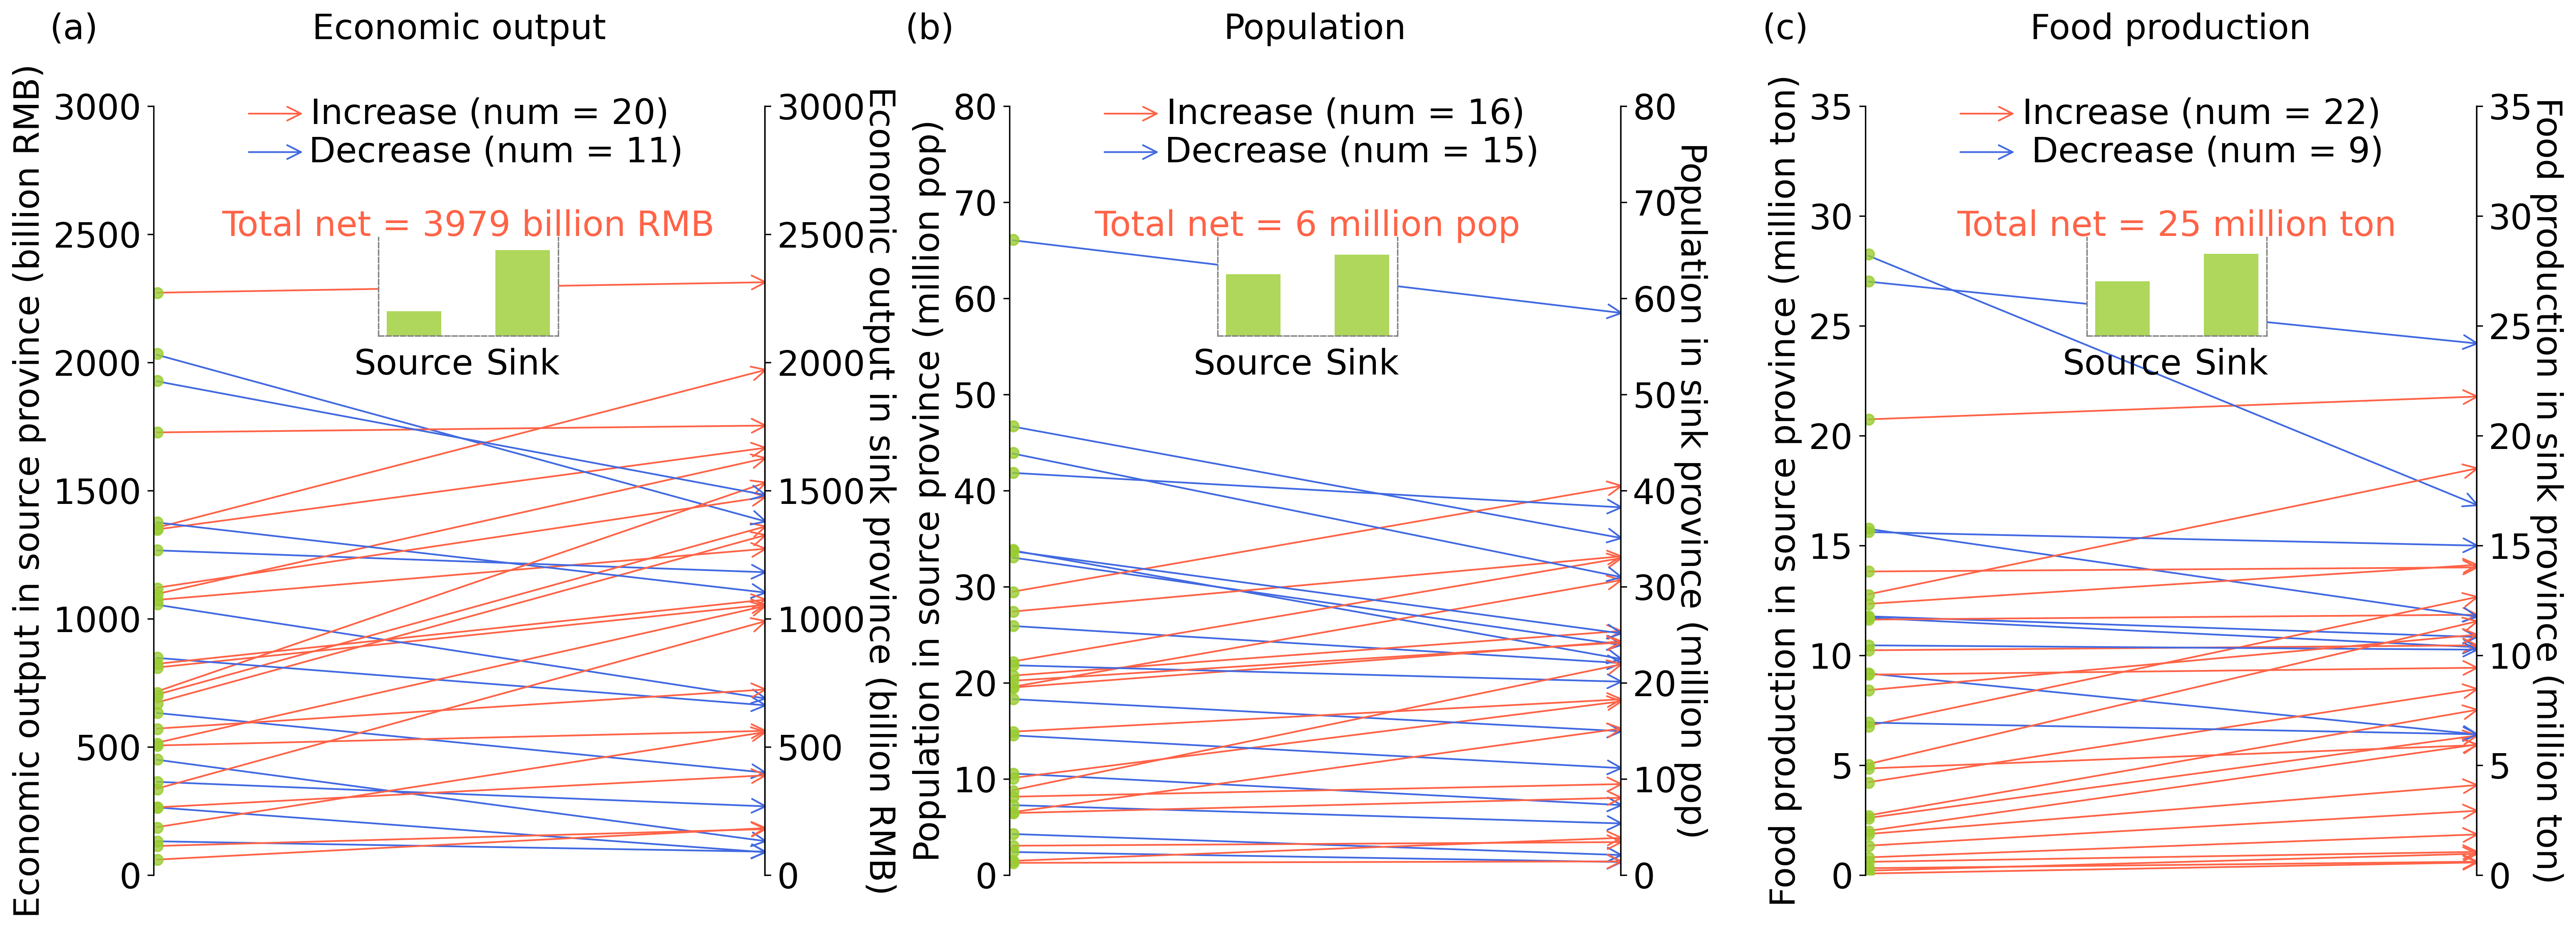

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

def arrow_data(data,unit_data,m1,m2):   
    data_h = pd.read_csv('../data/society/GDP&waterwithdrawal.csv')
    data_preelative = pd.read_csv('../data/ET&pre/prec_source_zonal0601.csv')

    pro_ETpreelative = np.array(data_preelative.iloc[0:31,1:32])
    water_withdrawal = np.array(data_h['sum_water_withdrawal(108m3)']).reshape((1,31))
    socioeconomic_data = np.array(data_h[data]).reshape((1,31))
    per_unit_water_socio = np.array(data_h[unit_data]).reshape((1,31))
    
    # m1, m2 unit adjust
    water_ECOvalue_outerunit = pro_ETpreelative * socioeconomic_data * m1
    water_ECOvalue_innerunit = pro_ETpreelative * water_withdrawal * per_unit_water_socio.reshape((31,1)) * m2

    water_ECOvalue_outerunit_sum = water_ECOvalue_outerunit.sum(axis=1)
    water_ECOvalue_innerunit_sum = water_ECOvalue_innerunit.sum(axis=1)
    water_ECOvalue_outerunit_total= water_ECOvalue_outerunit_sum.sum()
    water_ECOvalue_innerunit_total = water_ECOvalue_innerunit_sum.sum()
    net = water_ECOvalue_outerunit_sum-water_ECOvalue_innerunit_sum
    count = np.sum(net > 0)

    print (water_ECOvalue_outerunit_total)
    print (water_ECOvalue_innerunit_total)

    return water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_total,water_ECOvalue_innerunit_total,count

def scatter_axes(ax1,ylim,yticks,ylabel1,ylabel2,unit,num):
    ax1.scatter([0.006]*31,water_ECOvalue_innerunit_sum,color='yellowgreen',alpha=0.8)
    # ax1.scatter(0,water_ECOvalue_innerunit_ave,color='red',s = 400,alpha=0.5)
    ax1.xaxis.set_visible(False)
    for i in ['top', 'bottom']:
        ax1.spines[i].set_visible(False)
    ax1.set_ylim(0,ylim)
    ax1.set_ylabel(ylabel1,fontsize=20)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.text(-0.13,1.1,unit,transform=ax1.transAxes, fontdict={'size': '20', 'color': 'black'},
                horizontalalignment='center', verticalalignment='center')
    ax1.text(0.5,1.1,num,transform=ax1.transAxes, fontdict={'size': '20', 'color': 'black'},
                horizontalalignment='center', verticalalignment='center')

    ax2 = ax1.twinx()
    ax2.set_xlim([0, 1])
    for i in ['top', 'bottom','left']:
        ax2.spines[i].set_visible(False)
    ax2.set_ylim(0,ylim)
    ax2.set_yticks(yticks)
    ax2.tick_params(axis='both', labelsize=20)
    ax2.set_ylabel(ylabel2,rotation = 270, ha='center', va='center',labelpad=8, fontsize=20)
    # ax2.text(1,1.05,unit,transform=ax1.transAxes, fontdict={'size': '16', 'color': 'black'},
    #         horizontalalignment='center', verticalalignment='center')

def arrow(ax,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_sum,color1,color2,count,label1,label2,yl1,yl2,ys):
    for d in range(water_ECOvalue_outerunit_sum.shape[0]):
        if water_ECOvalue_outerunit_sum[d] > water_ECOvalue_innerunit_sum[d]:
            color = 'tomato'
        else:
            color = 'royalblue'
        arrow = FancyArrowPatch((0,water_ECOvalue_innerunit_sum[d]), (1.01,water_ECOvalue_outerunit_sum[d]), color=color, arrowstyle='->', 
                                mutation_scale=20, alpha=1)
        ax.add_patch(arrow)
    # big arrow
    # arrow_s = FancyArrowPatch((0.01,water_ECOvalue_innerunit_ave), (1.04,water_ECOvalue_outerunit_ave), color='red', arrowstyle='->', 
    #                             mutation_scale=50, alpha=0.5,linewidth = 20)
    # ax.add_patch(arrow_s)

    # legend
    legend1= FancyArrowPatch((0.25,0.99), (0.15,0.99), transform=ax.transAxes, color='tomato', arrowstyle='<-', 
                                mutation_scale=20, alpha=1)
    ax.add_patch(legend1)
    ax.text(0.55, 0.99, label1+f'Increase (num = {count})', transform=ax.transAxes, ha='center', va='center', fontsize=20)

    legend2= FancyArrowPatch((0.25,0.94), (0.15,0.94), transform=ax.transAxes, color='royalblue', arrowstyle='<-', 
                                mutation_scale=20, alpha=1)
    ax.add_patch(legend2)
    ax.text(0.56, 0.94, label1+f'Decrease (num = {31-count})', transform=ax.transAxes, ha='center', va='center', fontsize=20)
    # big arrow text
    # ax.text(0.5, 0.85, label2 + ' value net flow', transform=ax.transAxes, ha='center', va='center',fontsize=16)

def bar_plot(axx,water_ECOvalue_innerunit_total,water_ECOvalue_outerunit_total,ymin,ymax,unitname):
    axx.bar([1,2],[water_ECOvalue_innerunit_total,water_ECOvalue_outerunit_total],color='yellowgreen', width=0.5, alpha = 0.8)
    axx.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=True)
    axx.spines['top'].set_linestyle('dashed')
    axx.spines['bottom'].set_linestyle('dashed')
    axx.spines['left'].set_linestyle('dashed')
    axx.spines['right'].set_linestyle('dashed')
    axx.spines['top'].set_color('white')
    axx.spines['right'].set_color('gray')
    axx.spines['bottom'].set_color('gray')
    axx.spines['left'].set_color('gray')
    axx.set_xticks([1, 2])
    axx.set_xticklabels(['Source','Sink'],fontdict={'size': '20', 'color': 'black'})
    axx.set_ylim([ymin,ymax])
    axx.text(0.5,1.1,f'Total net = {int(round(water_ECOvalue_outerunit_total-water_ECOvalue_innerunit_total,0))} {unitname}',
             transform=axx.transAxes,ha='center', va='center', fontsize=20, color='tomato',alpha = 1)

fig = plt.figure(figsize=(24, 8), dpi=300)
plt.subplots_adjust(wspace=0.4)

ax1 = fig.add_subplot(131) 
ax11 = fig.add_axes([0.20,0.65,0.06,0.1])
water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_total,water_ECOvalue_innerunit_total,count= arrow_data('sum_GDP_2020RMB(108)','per_unit_water_value(rmb_m3)',0.1,0.1)
arrow(ax1,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_sum,'','',count,'','Economic production',15.5,13.8,7)
scatter_axes(ax1,3000,[0, 500, 1000, 1500, 2000, 2500, 3000],
             'Economic output in source province (billion RMB)','Economic output in sink province (billion RMB)','(a)','Economic output')
bar_plot(ax11,water_ECOvalue_innerunit_total,water_ECOvalue_outerunit_total,25000,31500,'billion RMB')

ax2 = fig.add_subplot(132) 
ax21 = fig.add_axes([0.48,0.65,0.06,0.1])
water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_total,water_ECOvalue_innerunit_total,count = arrow_data('population(wanren)','per_unit_water_pop(pop_m3)',0.01,100)
arrow(ax2,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_sum,'','',count,'','Population',440,390,200)
scatter_axes(ax2,80,[0, 10, 20, 30, 40, 50, 60, 70, 80],
             'Population in source province (million pop)','Population in sink province (million pop)','(b)','Population')
bar_plot(ax21,water_ECOvalue_innerunit_total,water_ECOvalue_outerunit_total,605,635,'million pop')

ax3 = fig.add_subplot(133) 
ax31 = fig.add_axes([0.77,0.65,0.06,0.1])
water_ECOvalue_outerunit_sum,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_total,water_ECOvalue_innerunit_total,count = arrow_data('food_production(wan_t)','per_unit_water_food(ton_m3)',0.01,100)
arrow(ax3,water_ECOvalue_innerunit_sum,water_ECOvalue_outerunit_sum,'','',count,'','Food production',175,155,80)
scatter_axes(ax3,35,[0, 5, 10, 15, 20, 25, 30, 35],
             'Food production in source province (million ton)','Food production in sink province (million ton)','(c)','Food production')
bar_plot(ax31,water_ECOvalue_innerunit_total,water_ECOvalue_outerunit_total,220,310,'million ton')